# Recommender System: Collaborative Filtering
In this notebook we will take a look at how to perform collaborative filtering to create a recommender system for movie reviews.

In [1]:
import pandas as pd
import surprise
from jikanpy import Jikan
import numpy as np
import time

In [2]:
# The dataset, anime_id_title.csv contains a mapping between the anime's title and an integer value

anime_id_map = pd.read_csv('./data/anime_id_title.csv')
anime_id_map.head()

id_2_title = {id: title for id, title in zip(anime_id_map.anime_id, anime_id_map.title)}
title_2_id = {title: id for id, title in zip(anime_id_map.anime_id, anime_id_map.title)}

In [3]:
df = pd.read_csv('./data/user_ratings.csv')
df = df[['username','anime_id','my_score']]

#Map username to userID
username_to_id = {username: id for id, username in enumerate(df.username.unique())}
id_to_username = {id: username for id, username in enumerate(df.username.unique())}

df['username'] = df['username'].map(username_to_id)

In [4]:
# Anime cleaned contains details of all the anime within the dataset including the most highly ranked anime.
# If we run into the 'cold start' problem, we will suggest the most highly ranked anime for the user to watch.
anime_cleaned = pd.read_csv('./data/anime_cleaned.csv')
anime_cleaned = anime_cleaned[['title','score','scored_by','rank']]
anime_cleaned.head()

,title,score,scored_by,rank
0,Inu x Boku SS,7.63,139250,1274.0
1,Seto no Hanayome,7.89,91206,727.0
2,Shugo Chara!! Doki,7.55,37129,1508.0
3,Princess Tutu,8.21,36501,307.0
4,Bakuman. 3rd Season,8.67,107767,50.0


## Data Cleaning:

Our current dataset is too large and takes too long for our machine learning algorithm to compute. Therefore, we are going to reduce the size of the algorithm by following a couple steps:
- Remove anime that have less than or equal to 5000 ratings
- Remove user's that have less than or equal to 10 reviews
- Randomly select 5000 users to be part of the recommendation system.

One of the main drawbacks from reducing the size of our database is that we are also removing some rare anime from the dataset. Hence, we are only going to be able to recommend the more popular anime.

In [5]:
#anime with less than 10 ratings
reviews_per_anime = df.groupby('anime_id').count()
anime_few_reviews = reviews_per_anime[reviews_per_anime.username <= 5000].index.to_list()

#user's with less than 10 reviews
review_per_user = df.groupby('username').count()
users_few_reviews = review_per_user[review_per_user.anime_id <= 10].index.to_list()

#Remove anime with less than 10 ratings
df = df[~df['anime_id'].isin(anime_few_reviews)]

#Remove user's with less than 10 reviews
df = df[~df['username'].isin(users_few_reviews)]

In [6]:
#How many users are in the database? 108249

#Check the distribution of ratings per user
df.groupby('username').count().anime_id.hist(bins=25)

1178


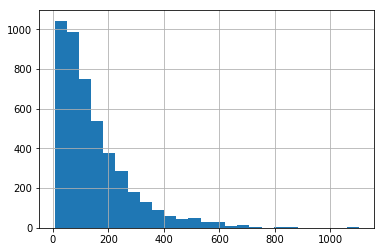

In [7]:
print(len(df.anime_id.unique()))
#Reduce the number of users in our data by randomly selecting 5000 ppl to include in our databasse
index = np.random.randint(low=0, high=len(df.username.unique()), size=5000)
df = df[df.username.isin(index)]

#Recheck our distribution of ratings per user to see if the random downsampling messed anything up
df.groupby('username').count().anime_id.hist(bins=25)

In [8]:
df.groupby('username').count()[df.groupby('username').count().anime_id == 11]

,anime_id,my_score
username,,
4605,11,11
22935,11,11
24228,11,11
26234,11,11
27221,11,11
28803,11,11
32482,11,11
36491,11,11
37212,11,11


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 677620 entries, 4611 to 19638203
Data columns (total 3 columns):
username    677620 non-null int64
anime_id    677620 non-null int64
my_score    677620 non-null int64
dtypes: int64(3)
memory usage: 20.7 MB


In [10]:
#According to surprise documentation: 
#https://surprise.readthedocs.io/en/stable/getting_started.html#use-a-custom-dataset
df = df.rename(columns={'username':'userID', 'anime_id':'itemID', 'my_score':'rating'})
reader = surprise.Reader(rating_scale=(0,10))
data = surprise.Dataset.load_from_df(df[['userID', 'itemID', 'rating']], reader)
algo = surprise.SVD()

#Train test split
trainset, testset = surprise.model_selection.train_test_split(data, test_size=.25)

# Train the algorithm on the trainset, and predict ratings for the testset
start = time.time()
algo.fit(trainset)
end = time.time()
print("Train time: {}".format(end - start))

start = time.time()
predictions = algo.test(testset)
end = time.time()
print("Prediction time: {}".format(end - start))

# Then compute RMSE
surprise.accuracy.mae(predictions)

Train time: 27.450247287750244
Prediction time: 1.7169861793518066
MAE:  1.2627


1.2627088411197127

In [11]:
# surprise.model_selection.cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

In [12]:
tmp = [pred for pred in predictions if pred.uid == 4605]
tmp

[Prediction(uid=4605, iid=68, r_ui=10.0, est=8.3463965627625, details={'was_impossible': False}),
 Prediction(uid=4605, iid=479, r_ui=10.0, est=8.781189296045477, details={'was_impossible': False})]

In [13]:
algo.predict(76525,552)

Prediction(uid=76525, iid=552, r_ui=None, est=6.748994986867969, details={'was_impossible': False})

# Grab my personal data from MAL and try to recommend me something to watch

In [15]:
jikan = Jikan()
freeMakintosh = jikan.user(username='FreeMakintosh', request='animelist')
freeMakintosh
# nekomata1037 = jikan.user(username='Nekomata1037', request='animelist')
# nekomata1037

{'request_hash': 'request:user:bdf28f9b904aaea9c575bf1173f39f6cdeb02aea',
 'request_cached': False,
 'request_cache_expiry': 300,
 'anime': [{'mal_id': 1575,
   'title': 'Code Geass: Hangyaku no Lelouch',
   'video_url': 'https://myanimelist.net/anime/1575/Code_Geass__Hangyaku_no_Lelouch/video',
   'url': 'https://myanimelist.net/anime/1575/Code_Geass__Hangyaku_no_Lelouch',
   'image_url': 'https://cdn.myanimelist.net/images/anime/5/50331.jpg?s=e609117c9d8a2ec41fca1ac249680386',
   'type': 'TV',
   'watching_status': 2,
   'score': 4,
   'watched_episodes': 25,
   'total_episodes': 25,
   'airing_status': 2,
   'season_name': None,
   'season_year': None,
   'has_episode_video': False,
   'has_promo_video': True,
   'has_video': True,
   'is_rewatching': False,
   'tags': None,
   'rating': 'R',
   'start_date': '2006-10-06T00:00:00+00:00',
   'end_date': '2007-07-29T00:00:00+00:00',
   'watch_start_date': None,
   'watch_end_date': None,
   'days': None,
   'storage': None,
   'priori

In [16]:
len(df.itemID.unique())

1178

In [18]:
my_list = [anime['title'] for anime in freeMakintosh['anime']]
my_list = [anime for anime in my_list if anime in title_2_id]
my_list

['Code Geass: Hangyaku no Lelouch',
 'Death Note',
 'Fullmetal Alchemist: Brotherhood',
 'Great Teacher Onizuka',
 'Haikyuu!!',
 'Hunter x Hunter (2011)',
 'Kuroko no Basket',
 'Kuroko no Basket 2nd Season',
 'Kuroko no Basket 3rd Season',
 'Made in Abyss',
 'Mobile Suit Gundam SEED',
 'Mobile Suit Gundam: Iron-Blooded Orphans',
 'Mobile Suit Gundam: Iron-Blooded Orphans 2nd Season',
 'No Game No Life',
 'One Punch Man',
 'Psycho-Pass',
 'Tengen Toppa Gurren Lagann']

In [19]:
testset

[(20042, 2759, 7.0),
 (79707, 24439, 6.0),
 (26890, 790, 9.0),
 (66261, 877, 10.0),
 (55593, 5081, 9.0),
 (13086, 29803, 9.0),
 (3100, 9041, 5.0),
 (36188, 10213, 7.0),
 (44423, 10863, 7.0),
 (29598, 528, 10.0),
 (62382, 487, 6.0),
 (31872, 157, 0.0),
 (22887, 10408, 10.0),
 (90885, 16866, 8.0),
 (73006, 371, 10.0),
 (336, 18893, 8.0),
 (14979, 174, 0.0),
 (49820, 223, 5.0),
 (90512, 11757, 9.0),
 (18230, 322, 2.0),
 (78578, 13759, 9.0),
 (30055, 2001, 10.0),
 (55981, 1361, 10.0),
 (26256, 11843, 10.0),
 (11703, 3731, 7.0),
 (49489, 6512, 7.0),
 (34982, 21881, 7.0),
 (42214, 904, 5.0),
 (47892, 5630, 9.0),
 (95023, 2963, 7.0),
 (98083, 16732, 8.0),
 (14279, 17247, 5.0),
 (6665, 3503, 0.0),
 (83287, 356, 9.0),
 (78417, 32, 7.0),
 (39320, 459, 7.0),
 (20042, 1074, 0.0),
 (47701, 5909, 8.0),
 (37942, 433, 8.0),
 (39875, 20159, 7.0),
 (63576, 19221, 0.0),
 (97186, 19815, 9.0),
 (49646, 1943, 8.0),
 (52259, 535, 8.0),
 (40749, 7148, 9.0),
 (5519, 43, 8.0),
 (20794, 572, 7.0),
 (32511, 18229